# Phase 0: EDA 

### Basic Overview

In [1]:
import pandas as pd

df = pd.read_csv("./data/beijing.csv")

# Basic info
print("Shape: ", df.shape)
print("Dtypes:\n",df.dtypes)
print(df.head())

# Quick stats
print(df.describe())


Shape:  (25892, 20)
Dtypes:
 year             int64
month            int64
day              int64
hour             int64
zone             int64
city            object
longitude      float64
latitude       float64
aqi              int64
co             float64
no             float64
no2            float64
o3             float64
so2            float64
pm2_5          float64
pm10           float64
nh3            float64
temperature    float64
dewpt          float64
date            object
dtype: object
   year  month  day  hour  zone     city  longitude  latitude  aqi       co  \
0  2021      1    1     0    46  Beijing   116.3913   39.9062    4  1695.63   
1  2021      1    1     1    46  Beijing   116.3913   39.9062    4  2136.23   
2  2021      1    1     2    46  Beijing   116.3913   39.9062    4  2349.85   
3  2021      1    1     3    46  Beijing   116.3913   39.9062    4  2243.04   
4  2021      1    1     4    46  Beijing   116.3913   39.9062    4  1375.20   

       no    no2     o

### Missing Values Heatmap

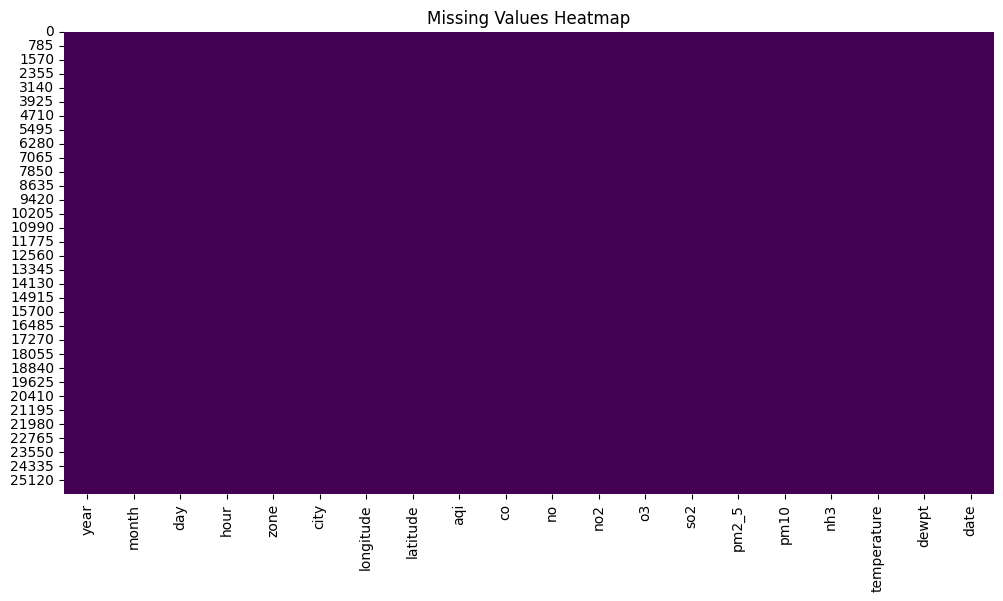

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()


### Histograms of Key Variables

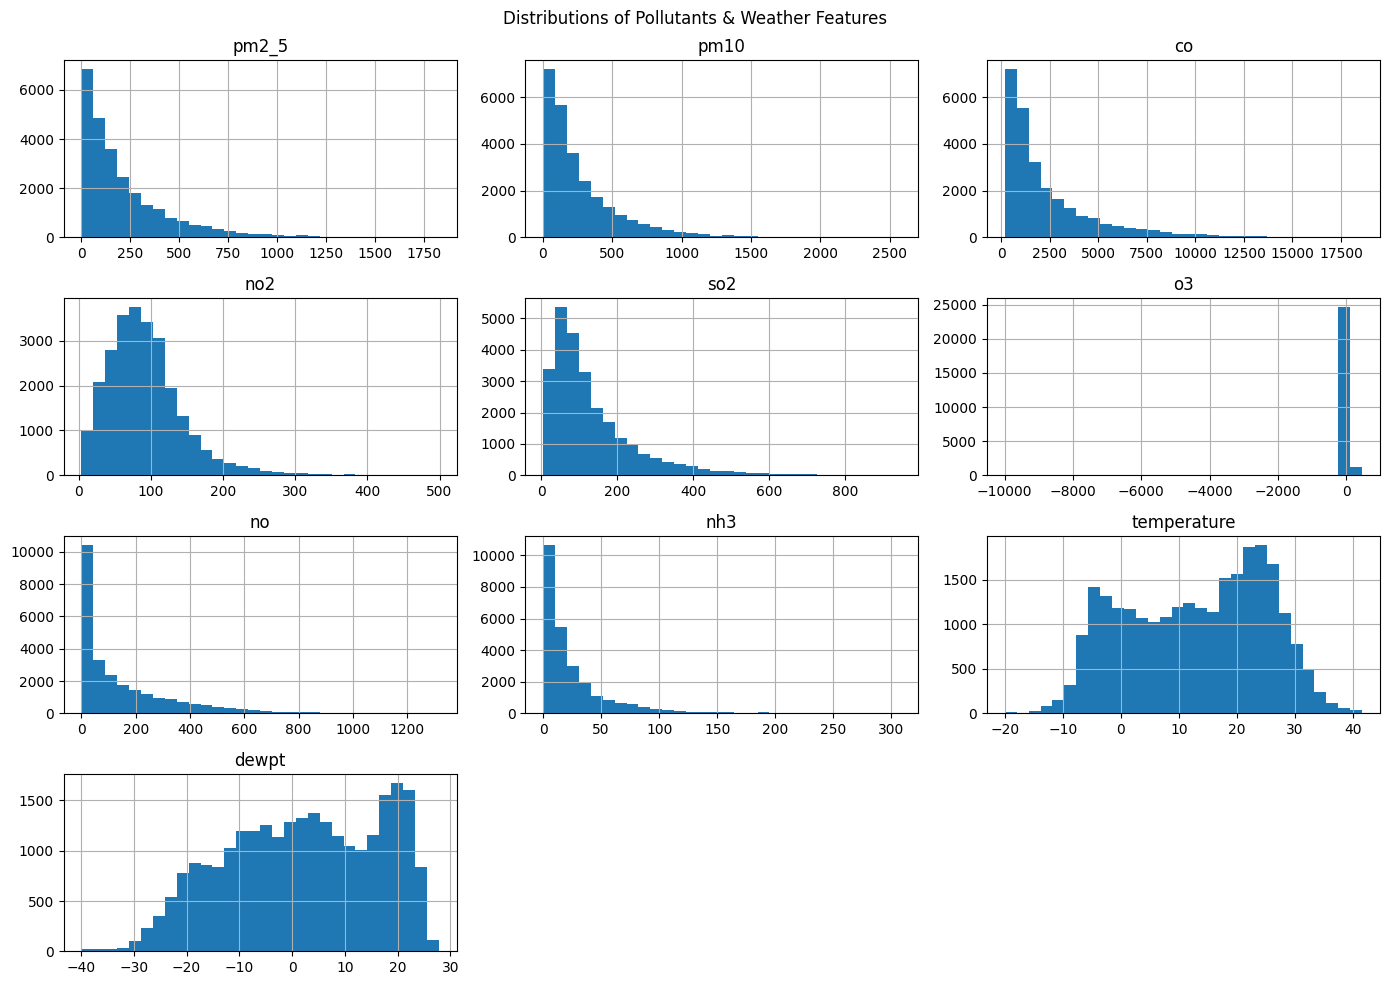

In [3]:
pollutants = ['pm2_5', 'pm10', 'co', 'no2', 'so2', 'o3', 'no', 'nh3']
weather = ['temperature', 'dewpt']

df[pollutants + weather].hist(figsize=(14, 10), bins=30)
plt.suptitle("Distributions of Pollutants & Weather Features")
plt.tight_layout()
plt.show()


### Time Series Plots

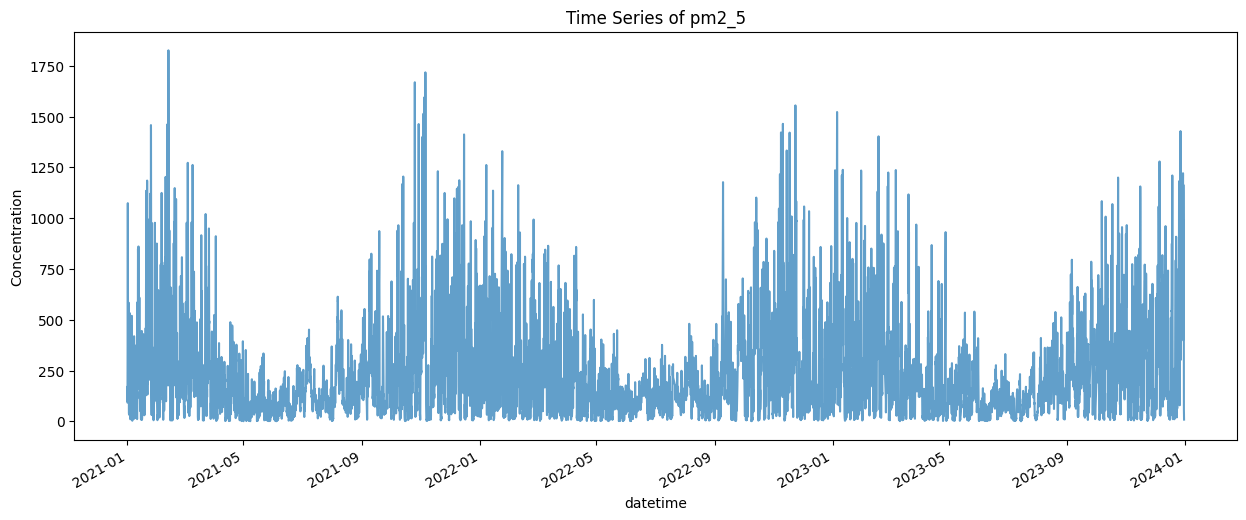

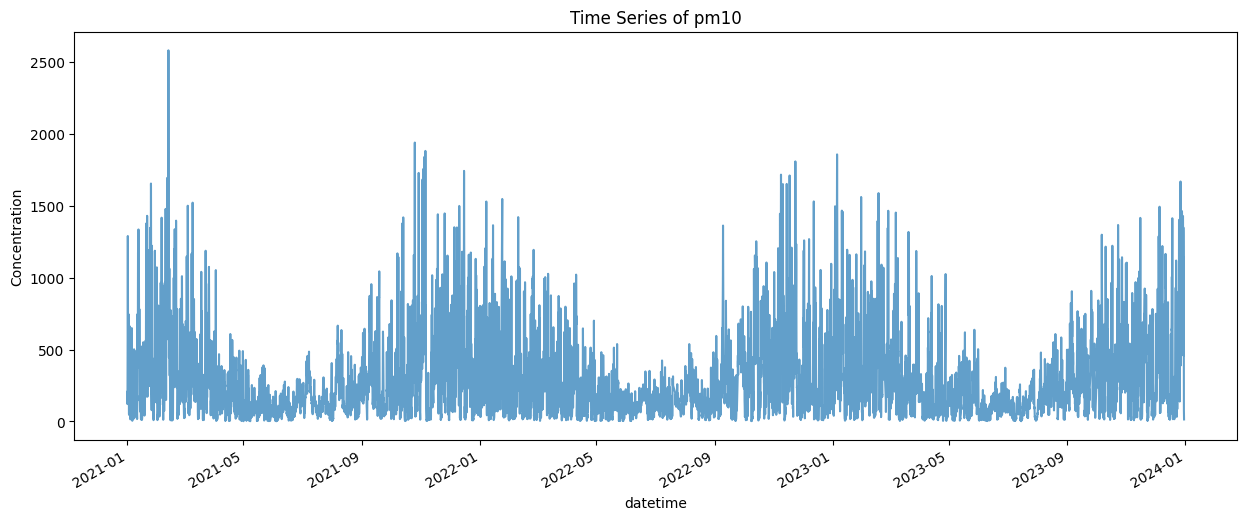

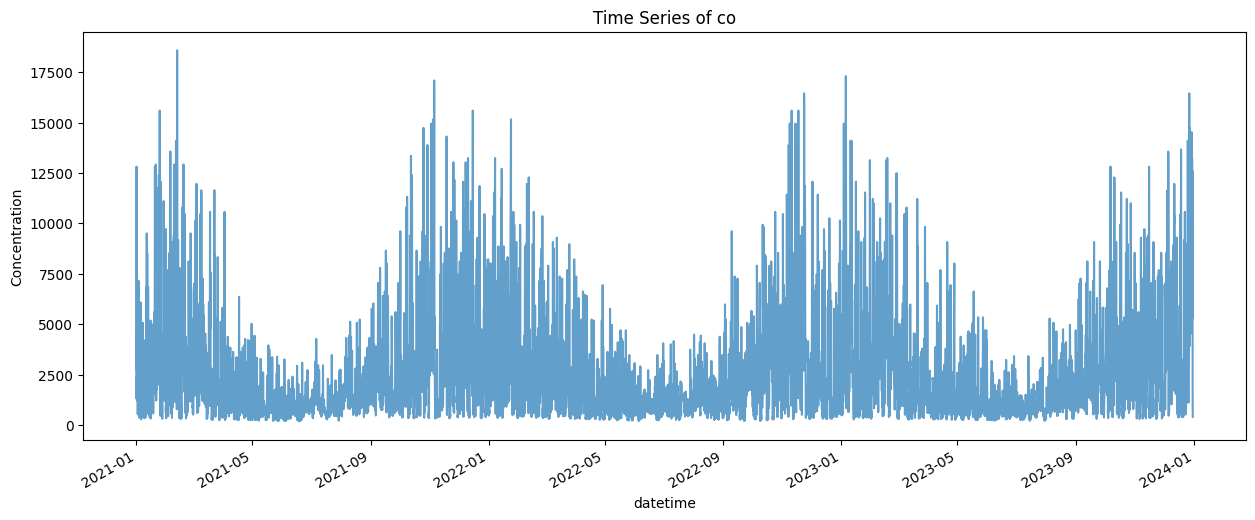

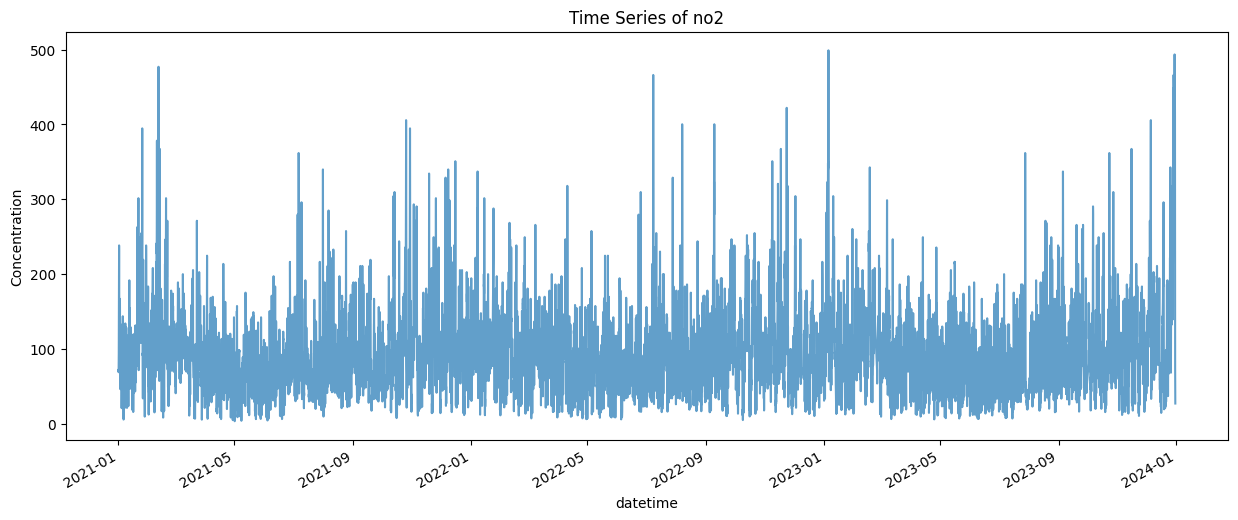

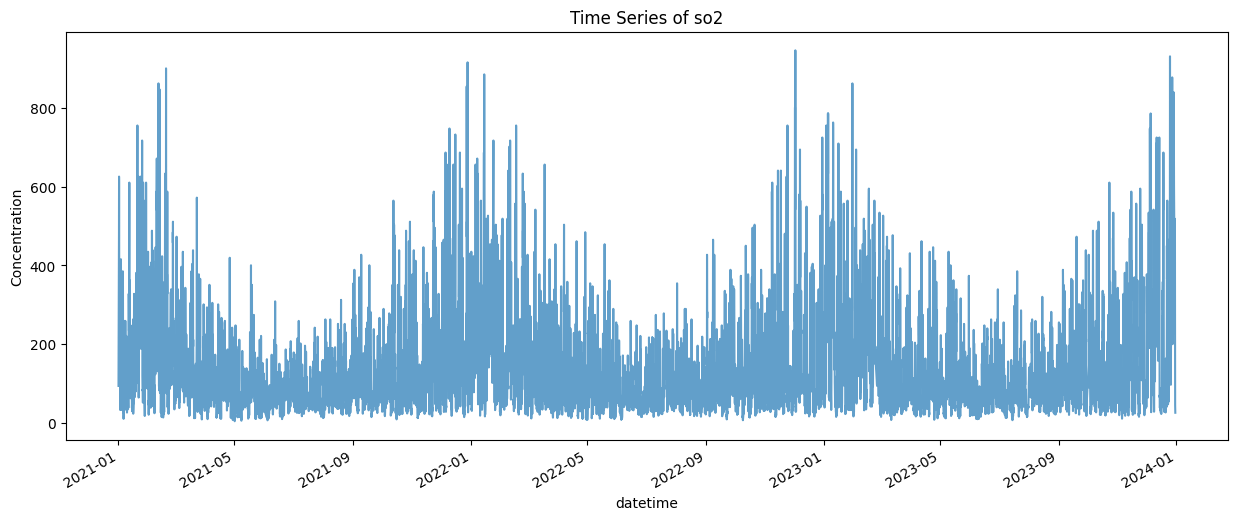

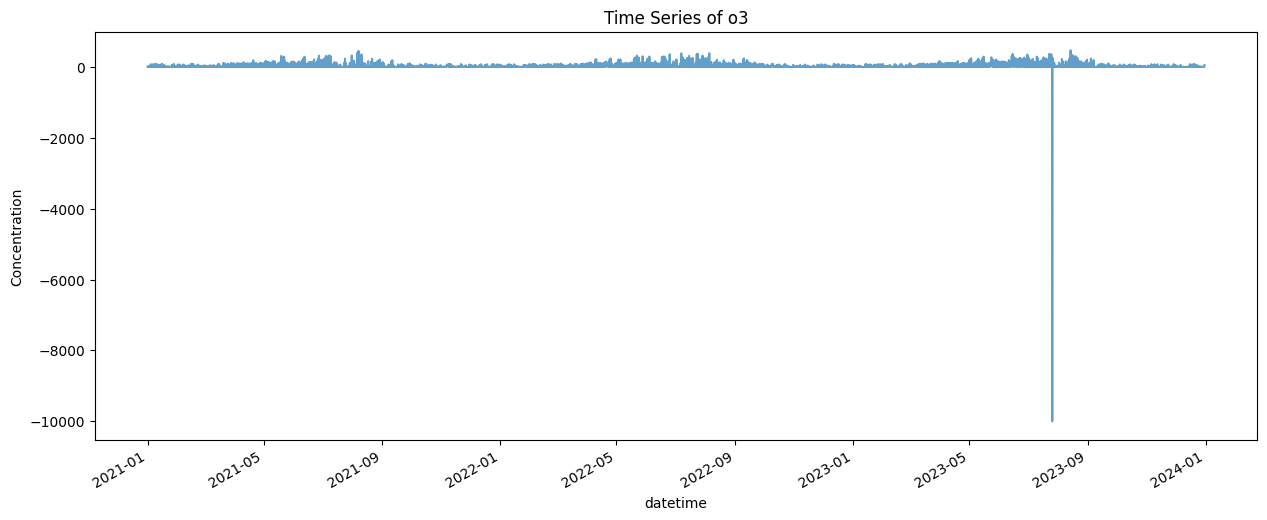

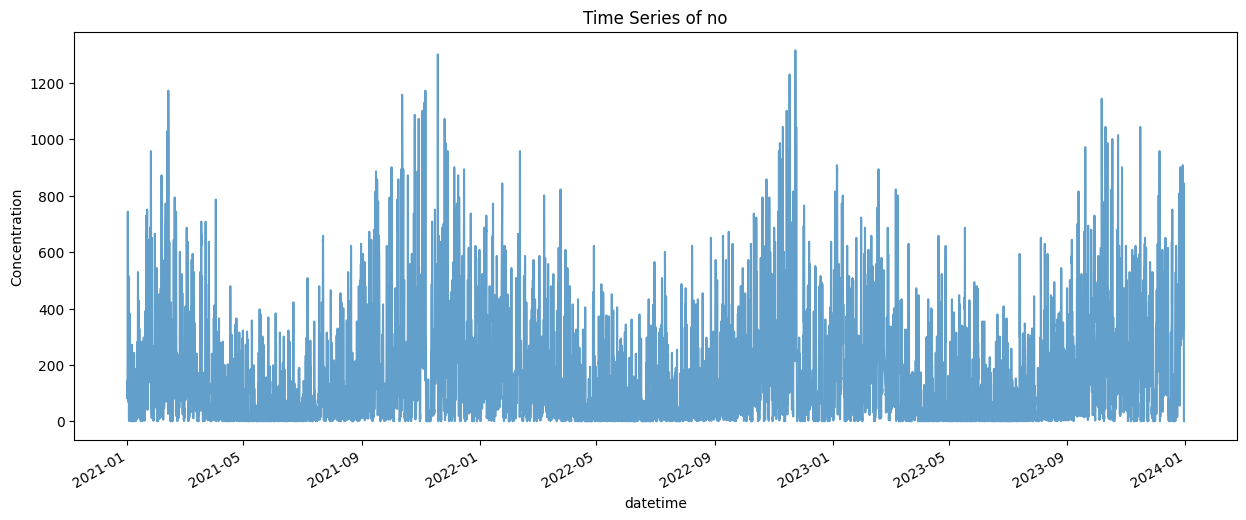

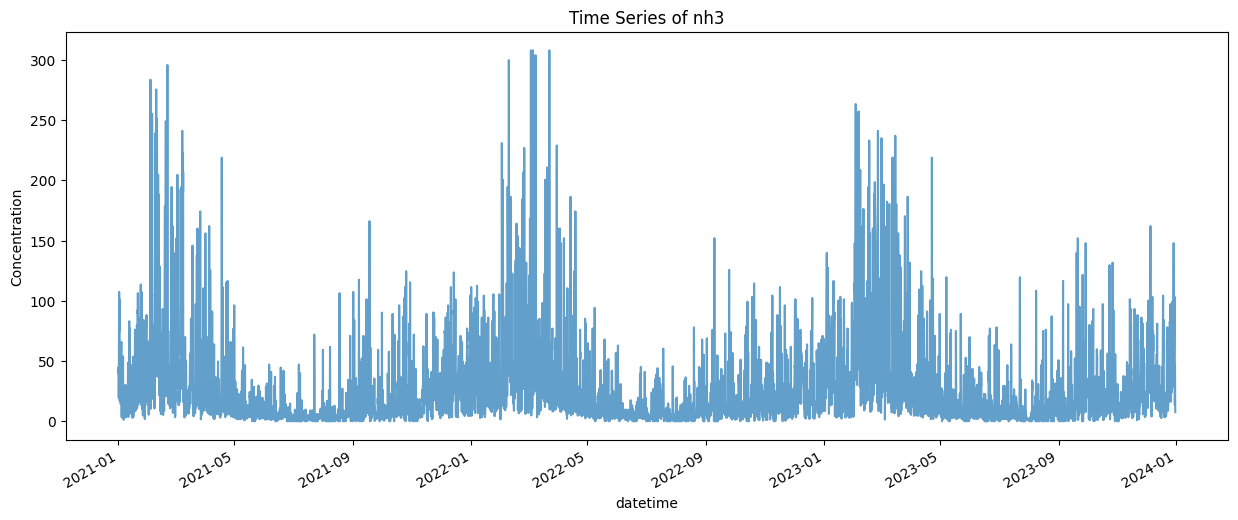

In [4]:
# Parse datetime
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('datetime', inplace=True)

for pollutant in pollutants:
# Plot pollutants over time
    df[pollutant].plot(figsize=(15, 6), alpha=0.7)
    plt.title(f"Time Series of {pollutant}")
    plt.ylabel("Concentration")
    plt.show()


### Correlation Heatmap

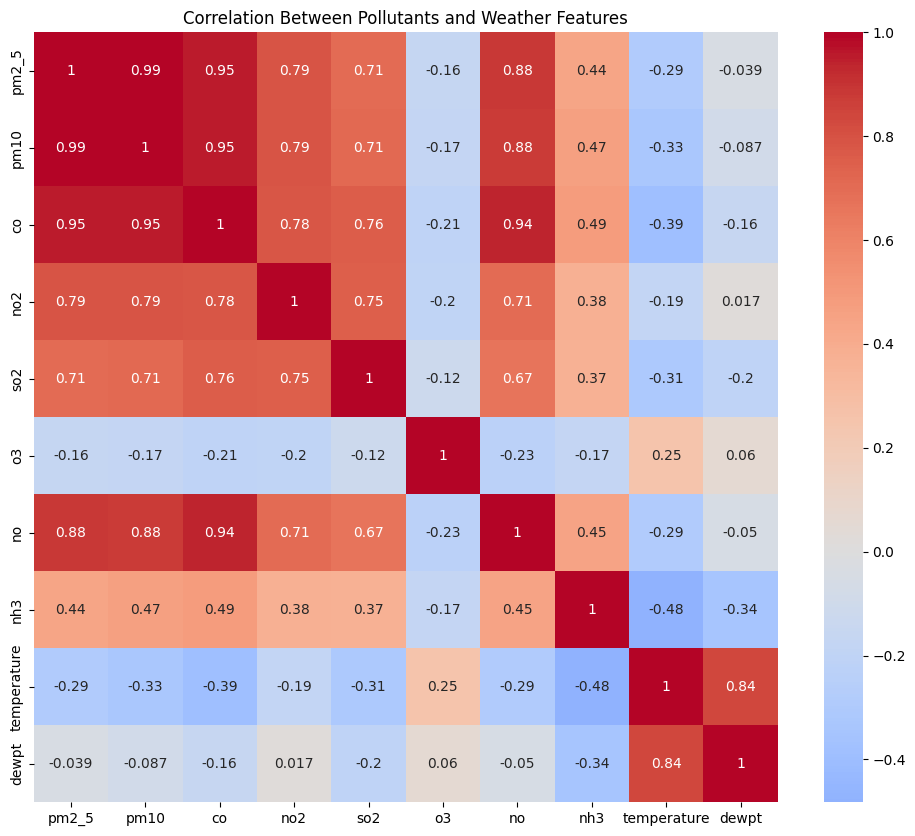

In [5]:
plt.figure(figsize=(12, 10))
corr = df[pollutants + weather].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Between Pollutants and Weather Features")
plt.show()


### Hourly/Daily Patterns

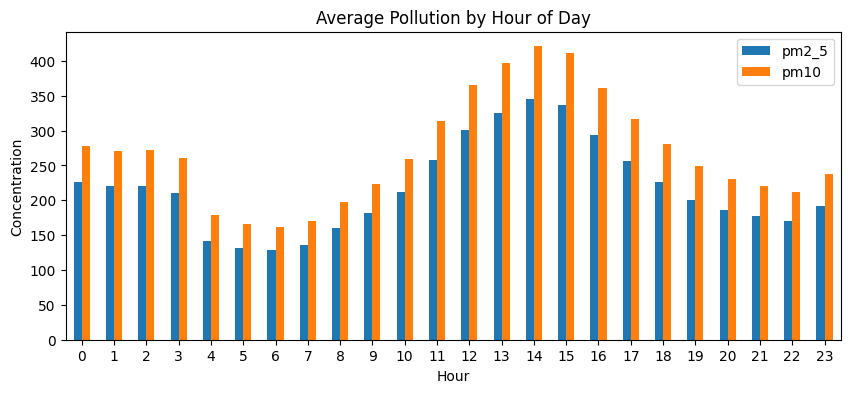

In [6]:
# Hourly average pollution
hourly_avg = df.groupby(df.index.hour)[['pm2_5', 'pm10']].mean()

hourly_avg.plot(kind='bar', figsize=(10, 4))
plt.title("Average Pollution by Hour of Day")
plt.ylabel("Concentration")
plt.xlabel("Hour")
plt.xticks(rotation=0)
plt.show()


# Phase 1: Data Preparation

### Load Data & Parse Datetime

In [7]:
# Load CSV
df = pd.read_csv("./data/beijing.csv")

# Combine year, month, day, hour into datetime
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

# Set datetime as index
df.set_index('datetime', inplace=True)

# Drop any redundant columns if desired
df.drop(columns=['year', 'month', 'day', 'hour', 'zone', 'city', 'longitude', 'latitude', 'date', 'aqi'], inplace=True)

# Sort by datetime
df = df.sort_index()

df.tail()


,co,no,no2,o3,so2,pm2_5,pm10,nh3,temperature,dewpt
datetime,,,,,,,,,,
2023-12-30 15:00:00,1028.06,8.38,75.40,2.62,45.30,57.89,76.62,14.31,-0.7,-10.0
2023-12-30 16:00:00,781.06,3.27,67.86,8.49,34.81,36.46,51.50,13.43,-1.2,-10.7
2023-12-30 17:00:00,580.79,0.34,50.72,27.54,29.33,21.13,31.18,11.27,-1.0,-11.3
2023-12-30 18:00:00,467.30,0.04,35.30,45.42,27.18,13.32,20.03,9.12,-1.0,-12.0
2023-12-30 19:00:00,407.22,0.01,27.42,53.64,26.23,8.98,14.11,7.60,-1.4,-12.2


### Outlier Handling

In [8]:
from scipy.stats import zscore

# Z-score outlier removal for numeric columns
z_scores = df.apply(zscore)
df = df[(z_scores < 3).all(axis=1)]  # Keep only within 3 std dev

df.shape


(24069, 10)

### Cleanup and Scaling

In [9]:
# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Ready for modeling
df_scaled.to_csv("./data/beijing_preprocessed.csv")


# Phase 2: Feature Selection

### Mutual Information (MI)

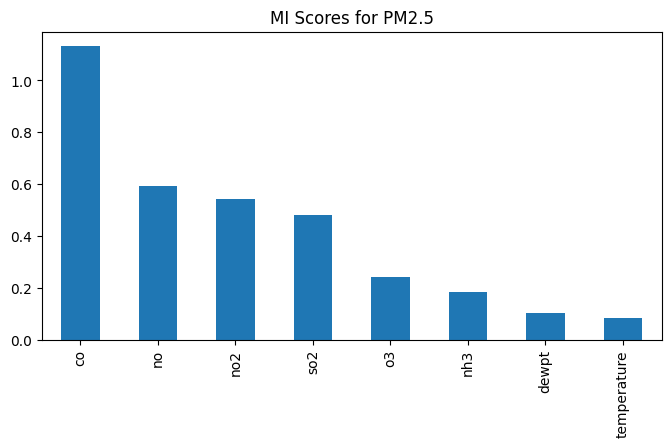

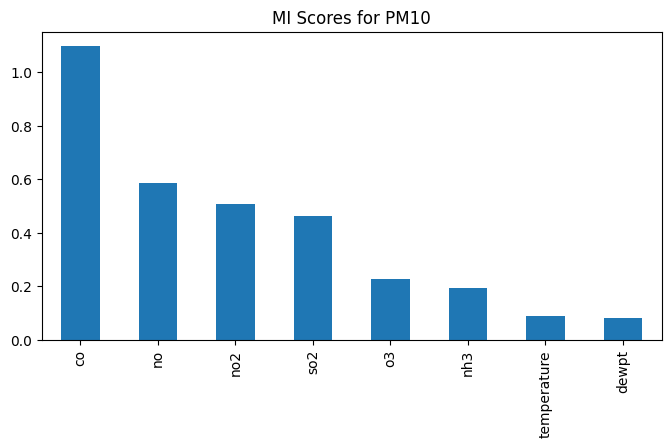

In [10]:
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import pandas as pd

# Load preprocessed dataset
df = pd.read_csv("./data/beijing_preprocessed.csv", parse_dates=['datetime'])
df.set_index('datetime', inplace=True)

features = ['co', 'no', 'no2', 'o3', 'so2', 'nh3', 'temperature', 'dewpt']

X = df[features]
y_pm25 = df['pm2_5']
y_pm10 = df['pm10']

# Mutual Information for PM2.5
mi_pm25 = mutual_info_regression(X, y_pm25)
mi_scores_pm25 = pd.Series(mi_pm25, index=features).sort_values(ascending=False)

# Mutual Information for PM10
mi_pm10 = mutual_info_regression(X, y_pm10)
mi_scores_pm10 = pd.Series(mi_pm10, index=features).sort_values(ascending=False)

# Plot
mi_scores_pm25.plot(kind='bar', title="MI Scores for PM2.5", figsize=(8, 4))
plt.show()

mi_scores_pm10.plot(kind='bar', title="MI Scores for PM10", figsize=(8, 4))
plt.show()


### mRMR (Minimum Redundancy Maximum Relevance)

In [11]:
import pymrmr

# pymrmr requires all numerical data and no NaNs
df_mrmr = df[features + ['pm2_5', 'pm10']].dropna()
df_mrmr = df_mrmr.reset_index(drop=True)

# mRMR for PM2.5 (returns top 5 features)
mrmr_pm25 = pymrmr.mRMR(df_mrmr.rename(columns={'pm2_5': 'target'}), 'MIQ', 5)

# mRMR for PM10
mrmr_pm10 = pymrmr.mRMR(df_mrmr.rename(columns={'pm10': 'target'}), 'MIQ', 5)

print("Top mRMR Features for PM2.5:", mrmr_pm25)
print("Top mRMR Features for PM10:", mrmr_pm10)




 *** This program and the respective minimum Redundancy Maximum Relevance (mRMR) 
     algorithm were developed by Hanchuan Peng <hanchuan.peng@gmail.com>for
     the paper 
     "Feature selection based on mutual information: criteria of 
      max-dependency, max-relevance, and min-redundancy,"
      Hanchuan Peng, Fuhui Long, and Chris Ding, 
      IEEE Transactions on Pattern Analysis and Machine Intelligence,
      Vol. 27, No. 8, pp.1226-1238, 2005.


*** MaxRel features ***
Order 	 Fea 	 Name 	 Score
1 	 9 	 pm10 	 0.419
2 	 8 	 target 	 0.412
3 	 1 	 no 	 0.382
4 	 4 	 so2 	 0.163
5 	 2 	 no2 	 0.162

*** mRMR features *** 
Order 	 Fea 	 Name 	 Score
1 	 9 	 pm10 	 0.419
2 	 1 	 no 	 1.377
3 	 6 	 temperature 	 1.604
4 	 4 	 so2 	 1.179
5 	 8 	 target 	 1.180


 *** This program and the respective minimum Redundancy Maximum Relevance (mRMR) 
     algorithm were developed by Hanchuan Peng <hanchuan.peng@gmail.com>for
     the paper 
     "Feature selection based on mutual info

# PHASE 3: Forecasting with NeuralProphet (PM2.5 Target)

### Prepare Data

In [153]:
# Load and format data
df = pd.read_csv("./data/beijing_preprocessed.csv", parse_dates=['datetime'])

# Select features
features = ['pm2_5', 'pm10', 'no', 'no2', 'co', 'so2', 'temperature']

# Rename columns for NeuralProphet
df = df[['datetime'] + features].rename(columns={'datetime': 'ds', 'pm2_5': 'y'})

# Drop NA just in case
df = df.dropna()

### Initial training to determine autoregression lags

In [128]:
from neuralprophet import NeuralProphet, set_log_level

set_log_level("ERROR")

# Define regressors upfront
regressors = ['pm10', 'no', 'no2', 'co', 'so2', 'temperature']

# Declare model with regressors
model = NeuralProphet(
    #learning_rate=1e-3,
    impute_missing=True,
    #drop_missing=True,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
)

model.set_plotting_backend("matplotlib")

model.add_lagged_regressor(regressors, n_lags=7)

# Fit the model
metrics = model.fit(df, progress=None, freq='H')

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:464: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experimen

Finding best initial lr:   0%|          | 0/259 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:79: UserWarning:

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 126. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.




In [129]:
metrics.tail(1)

,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss,epoch
39,0.009282,0.0,0.169615,0.292419,0.009282,0.0,39


WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1173: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.


WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._sho

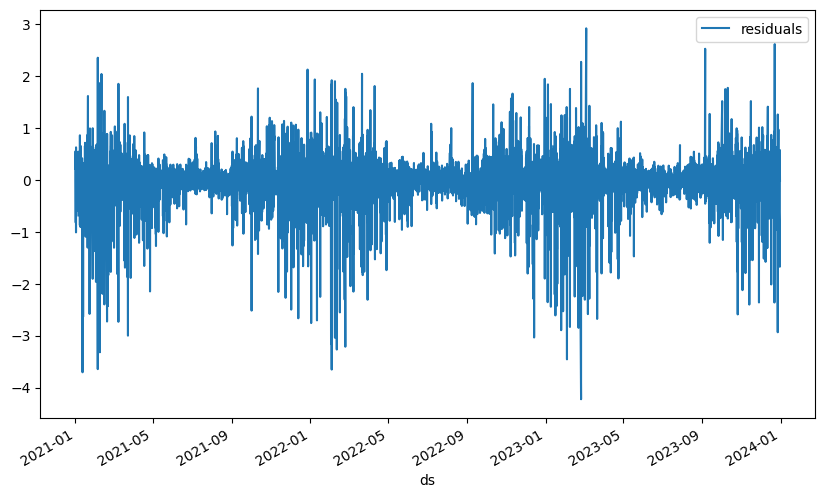

In [130]:
forecast = model.predict(df)
df_residuals = pd.DataFrame({"ds": df["ds"], "residuals": df["y"] - forecast["yhat1"]})
fig = df_residuals.plot(x="ds", y="residuals", figsize=(10, 6))

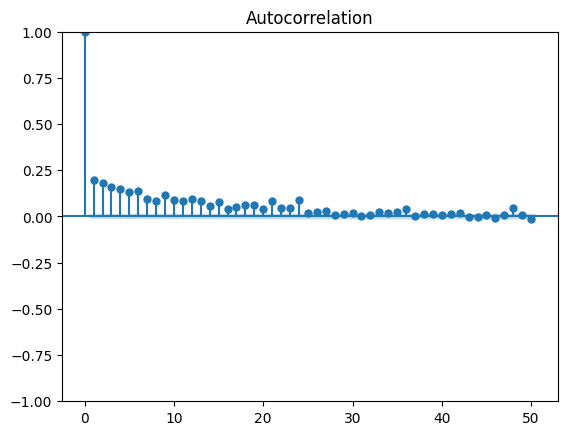

In [132]:
from statsmodels.graphics.tsaplots import plot_acf

plt = plot_acf(df_residuals["residuals"].dropna(), lags=50)

### Final Model Forecasting

In [166]:
from neuralprophet import NeuralProphet, set_log_level

set_log_level("ERROR")

# Define regressors upfront
regressors = ['pm10', 'no', 'no2', 'co', 'so2', 'temperature']

# Declare model with regressors
pm2_5_model = NeuralProphet(
    #learning_rate=1e-3,
    impute_missing=True,
    #drop_missing=True,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    #n_lags=5
)

test_hours = 24 * 7
df_train_val = df.iloc[:-test_hours].reset_index(drop=True)
df_test  = df.iloc[-test_hours:].reset_index(drop=True)

# 1) How many validation rows?
n_total = len(df)
n_val   = int(n_total * 0.1)        # 10% of df_train_val
n_train = n_total - n_val          # the rest

# 2) Slice
df_train = df_train_val.iloc[:n_train].reset_index(drop=True)
df_val  = df_train_val.iloc[n_train:].reset_index(drop=True)

# 3) Sanity check
print("Total:",      n_total)
print("Train rows:", len(df_train))
print("Val rows:  ", len(df_val))
print("Test rows:  ", len(df_test))
print("Sum check:", len(df_train) + len(df_val) + len(df_test))


Total: 24069
Train rows: 21663
Val rows:   2238
Test rows:   168
Sum check: 24069


In [167]:
pm2_5_model.set_plotting_backend("matplotlib")

pm2_5_model.add_lagged_regressor(regressors, n_lags=7)

# Fit the model
metrics = pm2_5_model.fit(df_train, validation_df=df_val, progress=None, freq='H')

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:464: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.




WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1173: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.


WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._sho

Finding best initial lr:   0%|          | 0/258 [00:00<?, ?it/s]

In [168]:
metrics.tail(1)

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss
39,0.237311,0.350451,0.019211,0.0,39,0.009269,0.0,0.165422,0.288641,0.009379,0.0


WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.




WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1173: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.


WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._sho

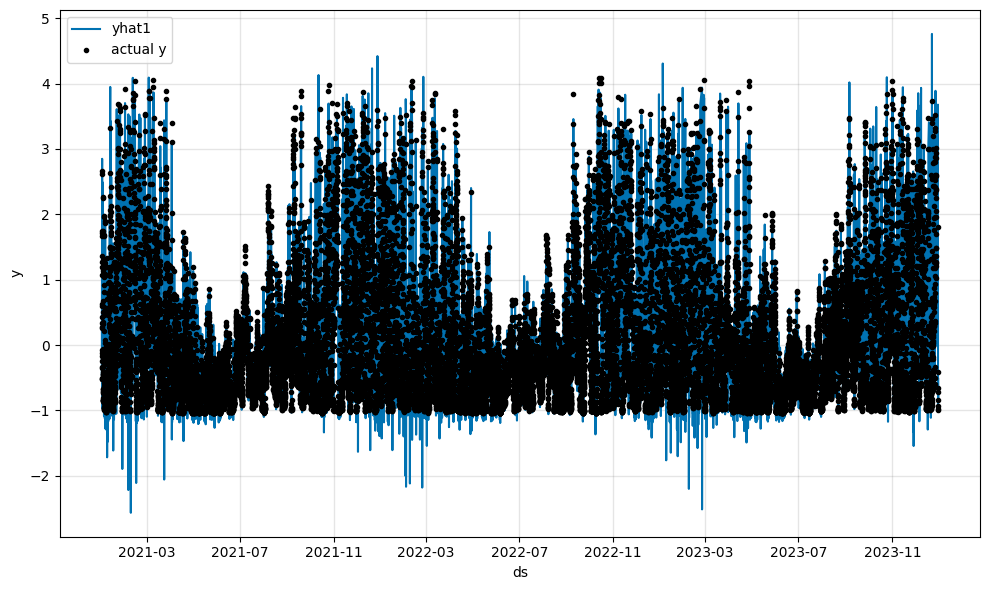

In [169]:
forecast = pm2_5_model.predict(df)
pm2_5_model.plot(forecast)

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1173: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.


WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._sho

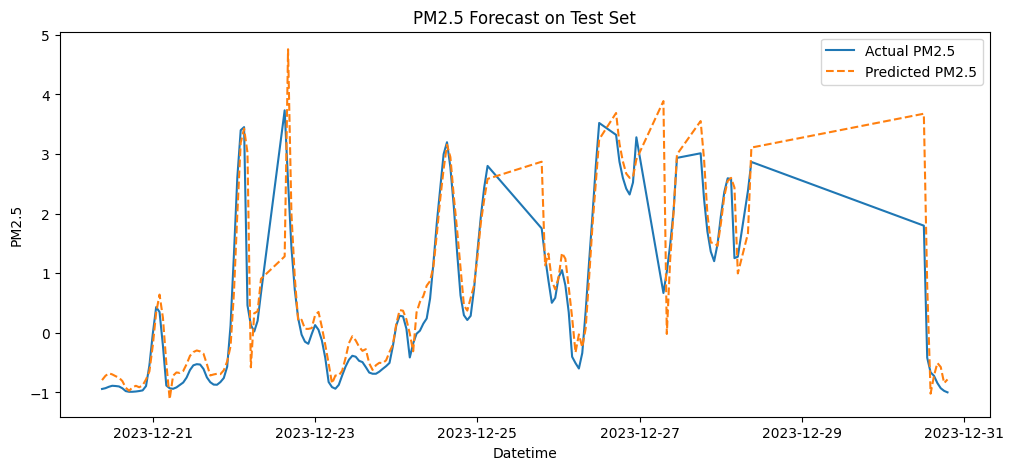

In [171]:
import matplotlib.pyplot as plt

# 1) Predict on the test set
forecast_test = pm2_5_model.predict(df_test)

# 2) Build two Series indexed by ds
pred = forecast_test.set_index('ds')['yhat1']
actual = df_test.set_index('ds')['y']

# 3) Align by joining on ds (inner join drops any extra/missing timestamps)
cmp_test = actual.to_frame('y').join(pred.to_frame('yhat1'), how='inner').dropna()

# 4) Plot Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(cmp_test.index, cmp_test['y'],    label='Actual PM2.5')
plt.plot(cmp_test.index, cmp_test['yhat1'], label='Predicted PM2.5', linestyle='--')
plt.title("PM2.5 Forecast on Test Set")
plt.xlabel("Datetime")
plt.ylabel("PM2.5")
plt.legend()
plt.show()


In [172]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# 5) Compute metrics
y_true = cmp_test['y']
y_pred = cmp_test['yhat1']

mae  = mean_absolute_error(y_true, y_pred)
rmse = root_mean_squared_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

print(f"Test MAE:  {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²:   {r2:.3f}")

Test MAE:  0.319
Test RMSE: 0.545
Test R²:   0.836


# PHASE 4: Forecasting with NeuralProphet (PM10 Target)

### Prepare Data

In [180]:
# Load and format data
df = pd.read_csv("./data/beijing_preprocessed.csv", parse_dates=['datetime'])

# Select features
features = ['pm2_5', 'pm10', 'no', 'no2', 'co', 'so2', 'temperature']

# Rename columns for NeuralProphet
df = df[['datetime'] + features].rename(columns={'datetime': 'ds', 'pm10': 'y'})

# Drop NA just in case
df = df.dropna()

### Final Model Forecasting

In [181]:
from neuralprophet import NeuralProphet, set_log_level

set_log_level("ERROR")

# Define regressors upfront
regressors = ['pm2_5', 'no', 'no2', 'co', 'so2', 'temperature']

# Declare model with regressors
pm10_model = NeuralProphet(
    #learning_rate=1e-3,
    impute_missing=True,
    #drop_missing=True,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    #n_lags=5
)

test_hours = 24 * 7
df_train_val = df.iloc[:-test_hours].reset_index(drop=True)
df_test  = df.iloc[-test_hours:].reset_index(drop=True)

# 1) How many validation rows?
n_total = len(df)
n_val   = int(n_total * 0.1)        # 10% of df_train_val
n_train = n_total - n_val          # the rest

# 2) Slice
df_train = df_train_val.iloc[:n_train].reset_index(drop=True)
df_val  = df_train_val.iloc[n_train:].reset_index(drop=True)

# 3) Sanity check
print("Total:",      n_total)
print("Train rows:", len(df_train))
print("Val rows:  ", len(df_val))
print("Test rows:  ", len(df_test))
print("Sum check:", len(df_train) + len(df_val) + len(df_test))


Total: 24069
Train rows: 21663
Val rows:   2238
Test rows:   168
Sum check: 24069


In [182]:
pm10_model.set_plotting_backend("matplotlib")

pm10_model.add_lagged_regressor(regressors, n_lags=7)

# Fit the model
metrics = pm10_model.fit(df_train, validation_df=df_val, progress=None, freq='h')

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:464: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experimen

Finding best initial lr:   0%|          | 0/258 [00:00<?, ?it/s]

In [183]:
metrics.tail(1)

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss
39,0.223738,0.335946,0.01757,0.0,39,0.008359,0.0,0.154839,0.275351,0.008329,0.0


WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change th

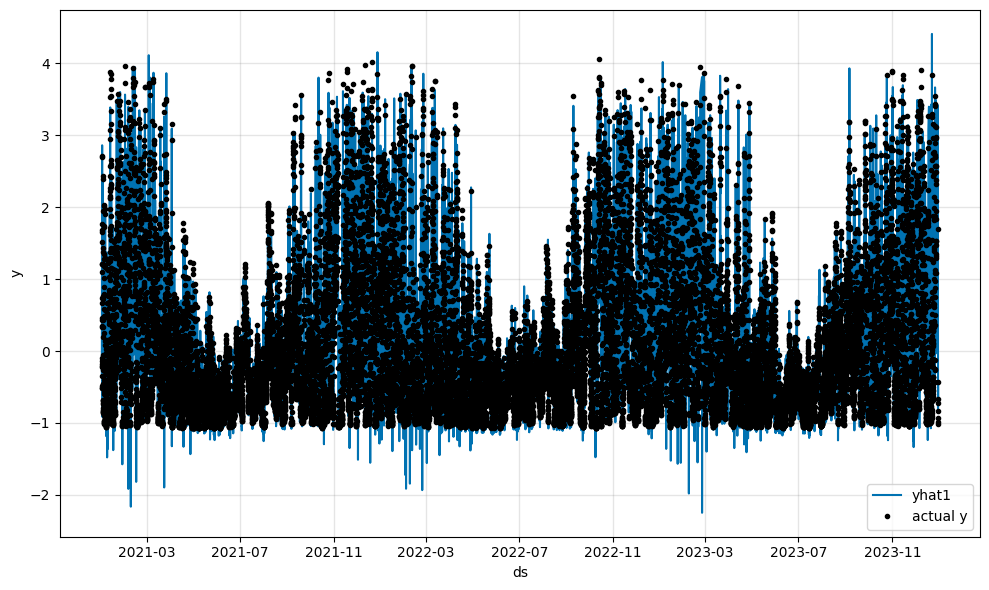

In [184]:
forecast = pm10_model.predict(df)
pm10_model.plot(forecast)

WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /home/moazzam/Documents/Windows/VS Code/Python/FL Research/Weather Forecasting - Experiments/venv/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change th

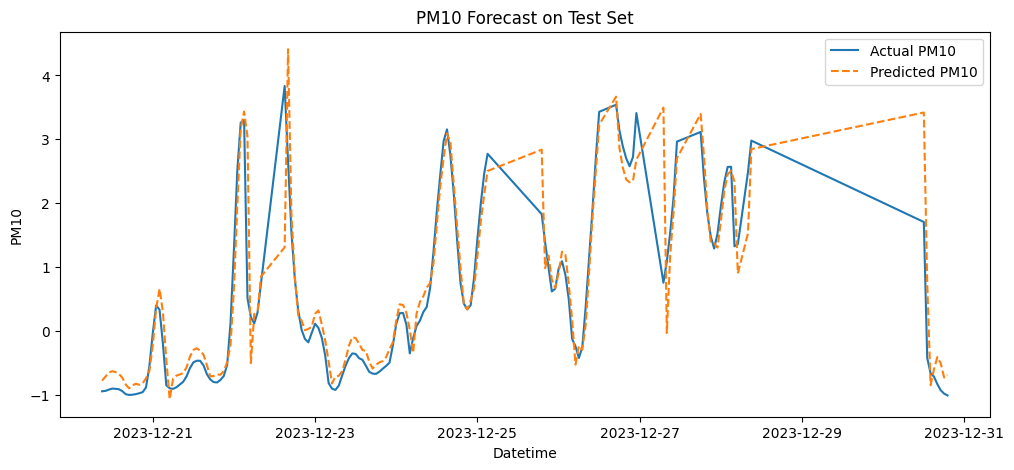

In [185]:
import matplotlib.pyplot as plt

# 1) Predict on the test set
forecast_test = pm10_model.predict(df_test)

# 2) Build two Series indexed by ds
pred = forecast_test.set_index('ds')['yhat1']
actual = df_test.set_index('ds')['y']

# 3) Align by joining on ds (inner join drops any extra/missing timestamps)
cmp_test = actual.to_frame('y').join(pred.to_frame('yhat1'), how='inner').dropna()

# 4) Plot Actual vs Predicted
plt.figure(figsize=(12,5))
plt.plot(cmp_test.index, cmp_test['y'],    label='Actual PM10')
plt.plot(cmp_test.index, cmp_test['yhat1'], label='Predicted PM10', linestyle='--')
plt.title("PM10 Forecast on Test Set")
plt.xlabel("Datetime")
plt.ylabel("PM10")
plt.legend()
plt.show()


In [186]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# 5) Compute metrics
y_true = cmp_test['y']
y_pred = cmp_test['yhat1']

mae  = mean_absolute_error(y_true, y_pred)
rmse = root_mean_squared_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

print(f"Test MAE:  {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²:   {r2:.3f}")

Test MAE:  0.292
Test RMSE: 0.501
Test R²:   0.864
